# Introduction:
This is a multilabel classification example. The aim of this machine learning project is predict acceptability of car.

# What Is Machine Learning Pipeline?

Machine learning pipeline is used to help automate machine learning workflows. They operate by enabling a sequence of data to be transformed and correlated together in a model that can be tested and evaluated to achieve an outcome.

# Algorithm:

Algorithm 1: Support Vector Machine (SVM)

Algorithm 2:Random Forest

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

k_fold = model_selection.KFold(n_splits=5, random_state=123)
from sklearn import tree

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from joblib import dump, load

# 1. Data Preparation
## 1.1 Import Car Evaluation Dataset

In [2]:
df = pd.read_csv(r'C:\Users\user\Desktop\Data_Science\Car\car_evaluation.csv')

## 1.2 Data Exploration

For each column the following statistics are presented in an interactive HTML report:

Essentials: type, unique values, missing values

Quantile statistics like minimum value, Q1, median, Q3, maximum, range, interquartile range

Descriptive statistics like mean, mode, standard deviation, sum, median absolute deviation, coefficient of variation, kurtosis, skewness
Most frequent values

Histogram

Correlations highlighting of highly correlated variables, Spearman, Pearson and Kendall matrices

Missing values matrix, count, heatmap and dendrogram of missing values

In [3]:
profile = ProfileReport(df)

In [4]:
profile.to_file(output_file="your_report.html")

### 1.2.1. Target Variable (Y) --- decision

In this dataset, "decision" variable refer to car acceptability.

Note that it is an imbalanced dataset. Imbalance means that the number of data points available for different the classes is different.

For imbalanced dataset, we need to pay attention to classification performance method.

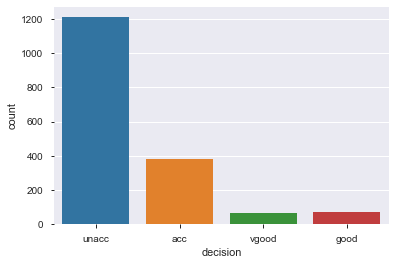

In [5]:
Y = df['decision']
ax = sns.countplot(Y)

### 1.2.2. Numeric Feature & Categorical Feature (X)

In [6]:
X = df.drop('decision', axis=1)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print("There are",X.shape[0], "rows and" , X.shape[1] , "feature(s) in dataset.")
print("-----------------------------------------------------------------------")

print("Number of numeric feature(s):",numeric_features.shape[0])
print("Variable(s) name:",numeric_features)
print("-----------------------------------------------------------------------")

print("Number of categorical feature(s):",categorical_features.shape[0])
print("Variable(s) name:",categorical_features)

There are 1728 rows and 6 feature(s) in dataset.
-----------------------------------------------------------------------
Number of numeric feature(s): 0
Variable(s) name: Index([], dtype='object')
-----------------------------------------------------------------------
Number of categorical feature(s): 6
Variable(s) name: Index(['buying_price', 'maintenance_cost', 'number_of_doors',
       'number_of_persons', 'lug_boot', 'safety'],
      dtype='object')


In [7]:
if numeric_features.shape[0] > 0:
    print(df[numeric_features].describe())
else:
    print("There is no numeric feature, skip this part")

There is no numeric feature, skip this part


In [8]:
if categorical_features.shape[0] > 0:
    print(df[categorical_features].describe())
else:
    print("There is no categorical feature, skip this part")

       buying_price maintenance_cost number_of_doors number_of_persons  \
count          1728             1728            1728              1728   
unique            4                4               4                 3   
top             med              med               2              more   
freq            432              432             432               576   

       lug_boot safety  
count      1728   1728  
unique        3      3  
top         med    med  
freq        576    576  


# 2. Preprocessing of Machine Learning

## 2.1. Handling Missing Value

if there are missing values, impute missing values before building an estimator. For numeric feature and categorical feature, impute missing value with median and "missing" respectively. In this dataset, there are no missing values. 

In [9]:
nulls = pd.DataFrame(df.isnull().sum().sort_values(ascending=False))
nulls.columns = ['Missing Value Count']
nulls.index.name = 'Feature'
print(nulls)

                   Missing Value Count
Feature                               
decision                             0
safety                               0
lug_boot                             0
number_of_persons                    0
number_of_doors                      0
maintenance_cost                     0
buying_price                         0


## 2.2.  Standardization of Numeric Feature

Standardize features by removing the mean and scaling to unit variance.

## 2.3. OneHot Encoding of Categorical Feature

One-hot encoding can be applied to the integer representation. This is where the integer encoded variable is removed and a new binary variable is added for each unique integer value.

In [10]:
# Define funcation to store encoded column name
def get_feature_names(columnTransformer):

    output_features = []

    for name, pipe, features in columnTransformer.transformers_:
        if name!='remainder':
            for i in pipe:
                trans_features = []
                if hasattr(i,'categories_'):
                    trans_features.extend(i.get_feature_names(features))
                else:
                    trans_features = features
            output_features.extend(trans_features)

    return output_features

In [11]:
# Preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder='passthrough')

In [12]:
preprocessor.fit(X)
encoded_feature_names = get_feature_names(preprocessor)
print(encoded_feature_names)

['buying_price_high', 'buying_price_low', 'buying_price_med', 'buying_price_vhigh', 'maintenance_cost_high', 'maintenance_cost_low', 'maintenance_cost_med', 'maintenance_cost_vhigh', 'number_of_doors_2', 'number_of_doors_3', 'number_of_doors_4', 'number_of_doors_5more', 'number_of_persons_2', 'number_of_persons_4', 'number_of_persons_more', 'lug_boot_big', 'lug_boot_med', 'lug_boot_small', 'safety_high', 'safety_low', 'safety_med']


# 3. Classification Model Setting

The following setting will be applied in each classification model.

## 3.1. Model Validation

To aviod overfitting or underfitting problem, 5-folds cross-validation has applied.

The data set is split into 5 folds. In the first iteration, the first fold is used to test the model and the rest are used to train the model. This process is repeated until each fold of the 5 folds have been used as the testing set.

In [13]:
k_fold = model_selection.KFold(n_splits=5, random_state=123)

## 3.2. Model Optimization

Turning model parameters with grid search.

## 3.3. Model Evaluation

The model selection criteria is balanced F-score in testing data.

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. 

Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). It can solve imbanlance dataset problem.

## 3.4. Speed up Training Time

Multiprocessing module to parallelize execution onto several Python processes by passing n_jobs = -2 as argument.

n_jobs = -2, all CPUs but one are used.

In [14]:
max_depth = [2,3,4]
min_samples_split = [0.1,0.2]

print("max_depth:",max_depth)
print("min_samples_split:",min_samples_split)

max_depth: [2, 3, 4]
min_samples_split: [0.1, 0.2]


if model exist, reload model. Otherwise, create new model and save it.

In [15]:
# Check if object exist
try:
    load('DT_pipeline.joblib') 
except FileNotFoundError:
    print("The model is not exist, now create & save model")
    
    DT_grid = {'classifier__max_depth': max_depth, 'classifier__min_samples_split': min_samples_split}
    
    DT_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', tree.DecisionTreeClassifier())])
    
    DT_model = GridSearchCV(DT_pipeline, 
                             DT_grid, cv=k_fold, scoring='f1_weighted',
                             return_train_score=True, n_jobs=-2)
    
    DT_model.fit(X,Y)
    # Save model in current folder 
    dump(DT_model, 'DT_pipeline.joblib')
else:
    DT_model = load('DT_pipeline.joblib')
    print("Reload existing model")

Reload existing model


## 4.2. Model Evaluation

## 4.3. Model Summary

In [16]:
DT_model.best_estimator_

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                      

## 4.3. Classification Result
Confusion matrix shows classification result.

In [17]:
CM = pd.crosstab(Y, DT_model.predict(X),rownames=['Actual'], colnames=['Predicted'])
print(CM)
print('--------------------------------')
print("DT model accuarcy:",round(sum(Y == DT_model.predict(X))/Y.count(),4)*100,"%")

Predicted  acc  unacc
Actual               
acc        384      0
good        69      0
unacc      250    960
vgood       65      0
--------------------------------
DT model accuarcy: 77.78 %


Text(0.5, 1, 'Confusion Matrix')

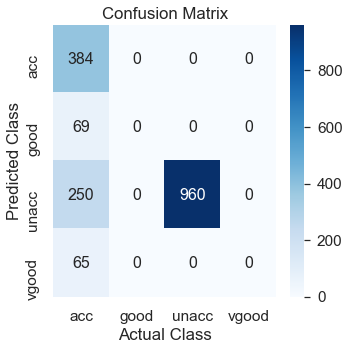

In [22]:
pred = DT_model.predict(X)
cm = confusion_matrix(Y, pred)

columns = np.unique(Y)

df_cm = pd.DataFrame(cm, index=columns, columns=columns)

plt.figure(figsize=(5,5))
sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, annot=True, fmt='g',cmap='Blues',annot_kws={"size": 16}) # font size
ax.set(xlabel='Actual Class', ylabel='Predicted Class')

ax.set_title('Confusion Matrix')

(1728, 21)
['buying_price_high' 'buying_price_low' 'buying_price_med'
 'buying_price_vhigh' 'maintenance_cost_high' 'maintenance_cost_low'
 'maintenance_cost_med' 'maintenance_cost_vhigh' 'number_of_doors_2'
 'number_of_doors_3' 'number_of_doors_4' 'number_of_doors_5more'
 'number_of_persons_2' 'number_of_persons_4' 'number_of_persons_more'
 'lug_boot_big' 'lug_boot_med' 'lug_boot_small' 'safety_high' 'safety_low'
 'safety_med']


[Text(223.20000000000002, 190.26, 'safety_low <= 0.5\nentropy = 0.457\nsamples = 1728\nvalue = [384, 69, 1210, 65]\nclass = unacc'),
 Text(167.4, 135.9, 'number_of_persons_2 <= 0.5\nentropy = 0.579\nsamples = 1152\nvalue = [384, 69, 634, 65]\nclass = unacc'),
 Text(111.60000000000001, 81.53999999999999, 'maintenance_cost_vhigh <= 0.5\nentropy = 0.629\nsamples = 768\nvalue = [384, 69, 250, 65]\nclass = acc'),
 Text(55.800000000000004, 27.180000000000007, '\n  (...)  \n'),
 Text(167.4, 27.180000000000007, '\n  (...)  \n'),
 Text(223.20000000000002, 81.53999999999999, 'entropy = 0.0\nsamples = 384\nvalue = [0, 0, 384, 0]\nclass = unacc'),
 Text(279.0, 135.9, 'entropy = 0.0\nsamples = 576\nvalue = [0, 0, 576, 0]\nclass = unacc')]

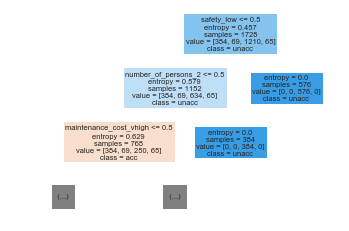

In [49]:
from sklearn.preprocessing import OneHotEncoder

a = df.drop('decision', axis=1)
b = df['decision']

# 1. INSTANTIATE
enc = OneHotEncoder()

# 2. FIT
enc.fit(a)

# 3. Transform
onehotlabels = enc.transform(a).toarray()
print(onehotlabels.shape)

feature_name = enc.get_feature_names(a.columns)
print(feature_name)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(onehotlabels, b)

tree.plot_tree(clf.fit(onehotlabels, b),
               max_depth=2,
               feature_names=feature_name,
               class_names=np.unique(b),
               filled=True)